In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
from torchvision import utils
from torch.optim import lr_scheduler

import numpy as np
import random

# For working with MATLAB data
import scipy.io as spio
import h5py

# For plotting
import matplotlib.pyplot as plt

import time
import os
import copy

# Set seed
random.seed(1)

# Dataset name
datasetName = "trainingAndTest_superEasy.mat"
#datasetName = "trainingAndTestSet.mat"

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Load data

In [2]:
# Setup the dataset class
class gaborDataset(Dataset):
    """Gabor Patches dataset."""

    def __init__(self, mat_file, train=True, transform=None):
        """
        Args:
            mat_file (string): Path to the .mat file (includes samplesCrop and labels variables).
            root_dir (string): Directory with the .mat file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        # Whether to use training set or test set
        self.train = train  
        
        # We don't actually need this atm, but let's keep it around just in case. 
        self.transform = transform
        
        # Read the data
        # mat = spio.loadmat(mat_file)
        
        mat = {}
        with h5py.File(mat_file, 'r') as f:
            for k, v in f.items():
                mat[k] = np.array(v)
                
        # Assume the mat contains the following:
        trainImages = mat['trainImages'] 
        trainLabels = mat['trainLabels'] 
        trainContrasts = mat['trainContrasts']
        trainFreqs = mat['trainFreqs']
        testImages = mat['testImages'] 
        testLabels = mat['testLabels'] 
        testContrasts = mat['testContrasts']
        testFreqs = mat['testFreqs']
        
        nTrain = trainLabels.shape[1]
        nTest = testLabels.shape[1]
        
        # Split training set
#         print("Splitting training set:")
#         trainImages = trainImages[0:300,:,:]
#         trainLabels = trainLabels[:,0:300]
#         trainContrasts = trainContrasts[:,0:300]
#         trainFreqs = trainFreqs[:,0:300]
        
        # Normalize the training set
        meanTrain = np.mean(trainImages)
        stdTrain = np.std(trainImages)
        trainImages = (trainImages - meanTrain)/stdTrain
        
        # Also normalize the test set but use the mean/std from training set
        testImages = (testImages - meanTrain)/stdTrain
        
        # Get unique values
        self.uniqueFreq = np.unique(testFreqs)
        self.uniqueCont = np.unique(testContrasts)
            
        # Use different data depending on whether we want the training or testing data
        if self.train:
            self.images = trainImages
            self.labels = np.squeeze(trainLabels)
            self.contrasts = np.squeeze(trainContrasts)
            self.freqs = np.squeeze(trainFreqs)
            
        else:
            self.images = testImages
            self.labels = np.squeeze(testLabels)
            self.contrasts = np.squeeze(testContrasts)
            self.freqs = np.squeeze(testFreqs)
            
    def __len__(self):   
        return len(self.labels)

    def __getitem__(self, idx):
        
        image = self.images[idx,:,:] # For h5py
        image = image.T
    
        # Easier to work with HxWxC
        image = np.expand_dims(image, axis=0)
        
        # Repeat in all three channels 
        #image = np.repeat(image[:, :, np.newaxis], 3, axis=2)

        # image = T.ToTensor()(image)
        
        sample = {'image': image, 'label': self.labels[idx],
                  'contrast': self.contrasts[idx], 'freq':self.freqs[idx],
                 'unique_contrasts': self.uniqueCont, 'unique_freqs':self.uniqueFreq}
    
        if self.transform:
            sample = self.transform(sample)

        return sample

TRAINING SET
Number of images: 500


/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10


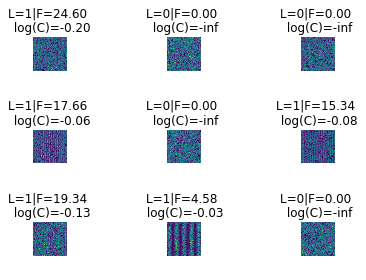

In [3]:
# Veirfy the gaborDataset class is working correctly

train_dataset = gaborDataset(datasetName,train=True)

fig = plt.figure()
  
print("TRAINING SET")    
print('Number of images: %i' % len(train_dataset))

for i in range(0,9):
    
    imSelect = random.randint(0,len(train_dataset)-1)
    sample = train_dataset[imSelect]
    
    ax = plt.subplot(3, 3, i + 1)
    plt.tight_layout()
    ax.set_title("L=%i|F=%0.2f \n log(C)=%0.2f" % (sample['label'],
                                                sample['freq'],
                                                   np.log10(sample['contrast'])))
    ax.axis('off')
    plt.imshow(np.squeeze(sample['image']))
   

TEST SET
Number of images: 1000


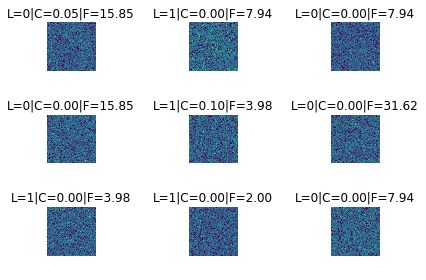

In [4]:
test_dataset = gaborDataset(datasetName,train=False)

fig = plt.figure()
  
print("TEST SET")    
print('Number of images: %i' % len(test_dataset))

for i in range(0,9):
    
    imSelect = random.randint(0,len(test_dataset)-1)
    sample = test_dataset[imSelect]
    
    ax = plt.subplot(3, 3, i + 1)
    plt.tight_layout()
    ax.set_title("L=%i|C=%0.2f|F=%0.2f" % (sample['label'],sample['contrast'],sample['freq']))
    ax.axis('off')
    plt.imshow(np.squeeze(sample['image']))
    

In [5]:
# Use the GPU if it's available

USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 1

print('using device:', device)

using device: cuda


In [6]:
NUM_TRAIN = 450
NUM_VAL = 50

if((NUM_TRAIN+NUM_VAL) > len(train_dataset)):
    print("NUM_TRAIN+NUM_VAL greater than size of dataset: %i" % len(train_dataset))
    
if((NUM_TRAIN+NUM_VAL) < len(train_dataset)):
    print("NUM_TRAIN+NUM_VAL is less than size of dataset: %i" % len(train_dataset))

gabor_train = gaborDataset(datasetName,train=True)
loader_train = DataLoader(gabor_train, batch_size=100, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

gabor_val = gaborDataset(datasetName,train=True)
loader_val = DataLoader(gabor_val, batch_size=100, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, NUM_TRAIN + NUM_VAL)))

# Helper function to show a batch
def show_batch(sample_batched):
    """Show image with label for a batch of samples."""
    images_batch, label_batch = \
            sample_batched['image'], sample_batched['label']
    batch_size = len(images_batch)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid[1,:,:])
    plt.title('Batch from dataloader')

Training Set:
0 torch.Size([100, 1, 224, 224])


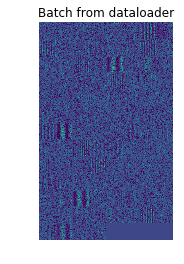

1 torch.Size([100, 1, 224, 224])


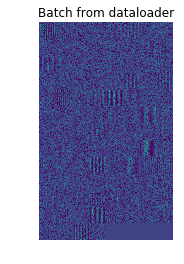

Validation Set:
0 torch.Size([50, 1, 224, 224])


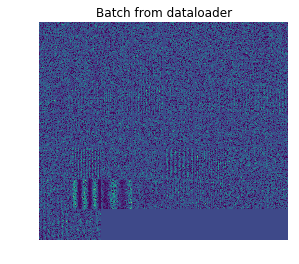

In [7]:
# Show a few batches:
print("Training Set:")
for i_batch, sample_batched in enumerate(loader_train):
    print(i_batch, sample_batched['image'].size())

    # observe first two batches
    if i_batch == 0:
        plt.figure()
        show_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        
    if i_batch == 1:
        plt.figure()
        show_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break
        
print("Validation Set:")
for i_batch, sample_batched in enumerate(loader_val):
    print(i_batch, sample_batched['image'].size())

    # observe first two batches
    if i_batch == 0:
        plt.figure()
        show_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        
    if i_batch == 1:
        plt.figure()
        show_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break
        

# Start training
Try a basic 2-layer ConvNet from the homework

In [8]:
import torch.nn.functional as F  # useful stateless functions

def train_part34(model, optimizer, scheduler, epochs=1):
    """
    Train a model using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: 
    - lossOutput: loss values as a list 
    """
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    lossHistory = []
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    
    for e in range(0,epochs):
        
        print('Epoch {}/{}'.format(e, epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        scheduler.step()
        model.train()  # Set model to training mode

        running_loss = 0.0
        running_corrects = 0

        for t, sample_batched in enumerate(loader_train): 

            x, y = sample_batched['image'], sample_batched['label']      

            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            y = np.squeeze(y)

            scores = model(x)
            _, preds = torch.max(scores, 1)

            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            
            # Print loss
            print("Iteration %i | Loss = %f" % (t,loss.item()))
            
            # statistics
            running_loss += loss.item() * x.size(0)
            lossHistory.append(loss.item())
            running_corrects += torch.sum(preds == y)

        epoch_loss = running_loss / len(gabor_train)
        epoch_acc = running_corrects.double() / len(gabor_train)
        
        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        # Evaluation phase
        model.eval()   # Set model to evaluate mode
        acc = check_accuracy_part34(loader_val, model)
        if(acc > best_acc):
            best_acc = acc
            best_model_wts = copy.deepcopy(model.state_dict())
        print()    

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, lossHistory

In [9]:
def check_accuracy_part34(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0

    falsePos = 0
    falseNeg = 0
    
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for sample_batched in loader:
            x, y, c, f = (sample_batched['image'], sample_batched['label'],
                          sample_batched['contrast'],sample_batched['freq'])
            
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            
#             print("preds:")
#             print(preds)
#             print("y:")
#             print(y)
            
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            
            falsePos += ((preds != y) & (y == 0)).sum()
            falseNeg += ((preds != y) & (y == 1)).sum()
            
            if(loader.dataset.train == False):
                correct_freq.append(f[(preds == y) & (y == 1)])
                incorrect_freq.append(f[(preds != y) & (y == 1)])
                
        acc = float(num_correct) / num_samples
        falseNegPerc = float(falseNeg) / float(num_samples-num_correct)
        falsePosPerc = float(falsePos) / float(num_samples-num_correct)
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        print('False negative: %d/%d (%0.2f)' % (falseNeg,num_samples-num_correct,100*falseNegPerc))
        print('False positive: %d/%d (%0.2f)' % (falsePos,num_samples-num_correct,100*falsePosPerc))
        
        return acc

In [25]:
# We need to wrap `flatten` function in a module in order to stack it
# in nn.Sequential
class Flatten(nn.Module):
    def forward(self, x):
        N = x.shape[0] # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

model = None
optimizer = None
       
model = nn.Sequential(
    
    nn.Conv2d(1, 5, kernel_size=11, stride=1, padding=2), # (224-11+2(2))/1 + 1 = 218
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    Flatten(),
    nn.Linear(109*109*5,120), 
    nn.ReLU(),
    nn.Linear(120,84),
    nn.ReLU(),
    nn.Linear(84,2),
    
#     # 224 input
    #nn.Conv2d(1,6,11,padding=2), # (224-11+2(2))/1 + 1 = 218
#     nn.Conv2d(1, 64, kernel_size=11, stride=1, padding=2), # (224-11+2(2))/1 + 1 = 218
#     nn.ReLU(),
#     nn.MaxPool2d(2,2), # 218/2 = 109
#     nn.Conv2d(64,16,4,padding=2), # (109-5+2(2))/1 + 1 = 110
#     nn.ReLU(),
#     nn.MaxPool2d(2,2), # 110/2 = 55
#     Flatten(),
# #     nn.Linear(55*55*16,120), 
#     nn.Linear(224*224*1,120), 
#     nn.ReLU(),
#     nn.Linear(120,84),
#     nn.ReLU(),
# #     nn.Dropout(),
#     nn.Linear(84,2)
    
    # 224 AlexNet
#     nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2), # (224 - 11 + 2(2)) / 4 + 1 = 55
#     nn.ReLU(inplace=True),
#     nn.MaxPool2d(kernel_size=3, stride=2), # (55 - 3) / 2 + 1 = 27
#     nn.Conv2d(64, 192, kernel_size=5, padding=2), # (27 - 5 + 2(2)) + 1= 27
#     nn.ReLU(inplace=True),
#     nn.MaxPool2d(kernel_size=3, stride=2), #(27 - 3) / 2 + 1= 13
#     nn.Conv2d(192, 384, kernel_size=3, padding=1), # (13 - 3 + 2(1)) / 1 + 1 = 13
#     nn.ReLU(inplace=True),
#     nn.Conv2d(384, 256, kernel_size=3, padding=1), # (13 - 3 + 2(1)) / 1 + 1 = 13
#     nn.ReLU(inplace=True),
#     nn.Conv2d(256, 256, kernel_size=3, padding=1), # (13 - 3 + 2(1)) / 1 + 1 = 13
#     nn.ReLU(inplace=True),
#     nn.MaxPool2d(kernel_size=3, stride=2), # (13 - 3) / 2 + 1 = 6
#     nn.Dropout(),
#     Flatten(),
#     nn.Linear(256 * 6 * 6, 4096),
#     nn.ReLU(inplace=True),
#     nn.Dropout(),
#     nn.Linear(4096, 4096),
#     nn.ReLU(inplace=True),
#     nn.Linear(4096, 2)
    
    # 128 input
#     nn.Conv2d(1,6,5), # (128-5+0)/1 + 1 = 124
#     nn.ReLU(),
#     nn.MaxPool2d(2,2), # 124/2 = 62
#     nn.Conv2d(6,16,5), # (62-5+0)/1 + 1 = 58
#     nn.ReLU(),
#     nn.MaxPool2d(2,2), # 58/2 = 29
#     Flatten(),
#     nn.Linear(29*29*16,120), 
#     nn.ReLU(),
#     nn.Linear(120,84),
#     nn.ReLU(),
#     nn.Linear(84,2)
    
)

learning_rate = 1e-3 #5e-2

# you can use Nesterov momentum in optim.SGD
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=1)

model,lossHistory = train_part34(model, optimizer, exp_lr_scheduler,
                       epochs=20)

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1525909934016/work/aten/src/THC/generic/THCStorage.cu:58

In [14]:
plt.plot(lossHistory)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

In [19]:
# Loading test set
gabor_test = gaborDataset(datasetName,train=False)

# Load data in batches
loader_test = DataLoader(gabor_test, batch_size=250)
print('Test data length: %i' % len(gabor_test))

Splitting training set:
Test data length: 1000


In [20]:
# Check the accuracy with the specific test set we are using.
def CSFtest(loader, model):
    if loader.dataset.train:
        print('Loader given was for training. Exiting.')
        return
    else:
        print('Checking accuracy on test set')   

    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for i_batch, sample_batched in enumerate(loader):
            x, y, c, f, uc, uf = (sample_batched['image'], sample_batched['label'],
              sample_batched['contrast'],sample_batched['freq'],
              sample_batched['unique_contrasts'],sample_batched['unique_freqs']) 
            
            uc = np.squeeze(uc[0,:])
            uf = np.squeeze(uf[0,:])
            
            if i_batch == 0:
                results = np.zeros((len(uc),len(uf),2))
                             
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)

            correct = (preds == y)
                             
            for cc in range(0,len(uc)):
                for ff in range(0,len(uf)):
                    goodI = (c == uc[cc])&(f == uf[ff])
                    curr_correct = correct[goodI]
                    num_correct = curr_correct.sum()
                    num_total = len(curr_correct)
                    results[cc,ff,0] += num_correct
                    results[cc,ff,1] += num_total

        return results, uc, uf

Checking accuracy on test set


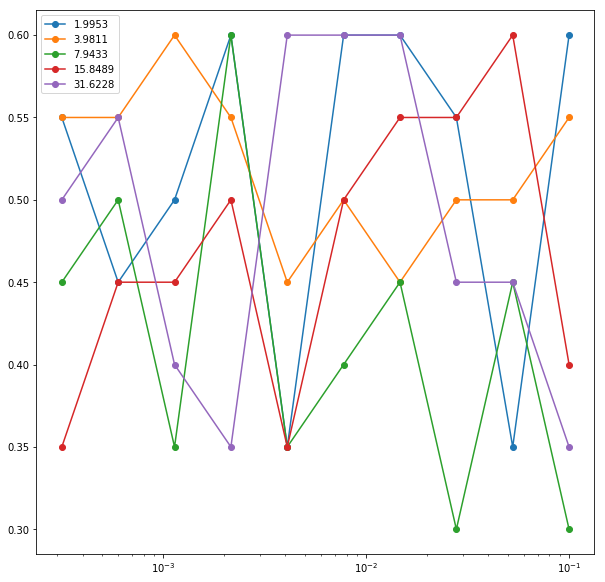

In [21]:
best_model = model
(results, unique_c, unique_f) = CSFtest(loader_test, best_model)

# print(results)

plt.figure(figsize=(10,10))

for ff in range(0,len(unique_f)):
    num_correct = results[:,ff,0]
    num_total = results[:,ff,1]
    curr_acc = np.divide(num_correct,num_total)
    plt.plot(unique_c.data.numpy(),curr_acc,'o-',label=('%0.4f' % unique_f[ff]))
    
plt.legend()
plt.xscale('log')


## Old stuff

In [133]:
# Visualize weights
# From: https://github.com/pedrodiamel/nettutorial/blob/master/pytorch/pytorch_visualization.ipynb

def vistensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    '''
    vistensor: visuzlization tensor
        @ch: visualization channel 
        @allkernels: visualization all tensores
    ''' 
    
    n,c,w,h = tensor.shape
    if allkernels: tensor = tensor.view(n*c,-1,w,h )
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)
        
    rows = np.min( (tensor.shape[0]//nrow + 1, 64 )  )    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

def savetensor(tensor, filename, ch=0, allkernels=False, nrow=8, padding=2):
    '''
    savetensor: save tensor
        @filename: file name
        @ch: visualization channel 
        @allkernels: visualization all tensores
    '''    

    n,c,w,h = tensor.shape
    if allkernels: tensor = tensor.view(n*c,-1,w,h )
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)    
    utils.save_image(tensor, filename, nrow=nrow )

In [135]:

for layer in best_model.modules():
   if isinstance(layer, nn.Linear):                  
        kernel = layer.weight.clone()
        print(kernel.shape)
        kernel = kernel.view((2,1,128,128))
        print(kernel.shape)
        break

vistensor(kernel.data, ch=0, allkernels=False)
# savetensor(kernel,'kernel.png', allkernels=False)

plt.axis('off')
plt.ioff()
plt.show()

torch.Size([120, 48400])


RuntimeError: invalid argument 2: size '[2 x 1 x 128 x 128]' is invalid for input with 5808000 elements at /opt/conda/conda-bld/pytorch_1525909934016/work/aten/src/TH/THStorage.c:41